C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20012\251424502.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['age'].fillna(customers_df['age'].median(), inplace=True)
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_20012\251424502.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

Mean Absolute Error (MAE): 862.5978885049561
Mean Squared Error (MSE): 1588734.8782661895
R-squared (R2): 0.9233083262560604
                            OLS Regression Results                            
Dep. Variable:                    clv   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.109e+04
Date:                Sun, 07 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:48:44   Log-Likelihood:                -68495.
No. Observations:                8000   AIC:                         1.370e+05
Df Residuals:                    7990   BIC:                         1.371e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025   

<Figure size 1000x600 with 0 Axes>

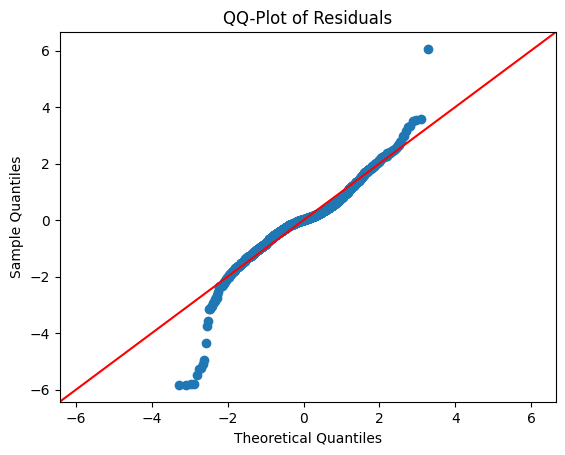

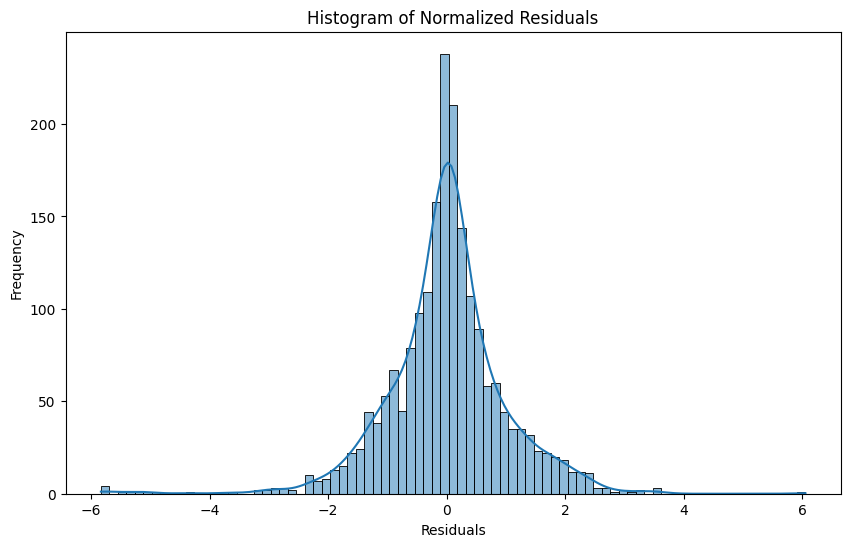

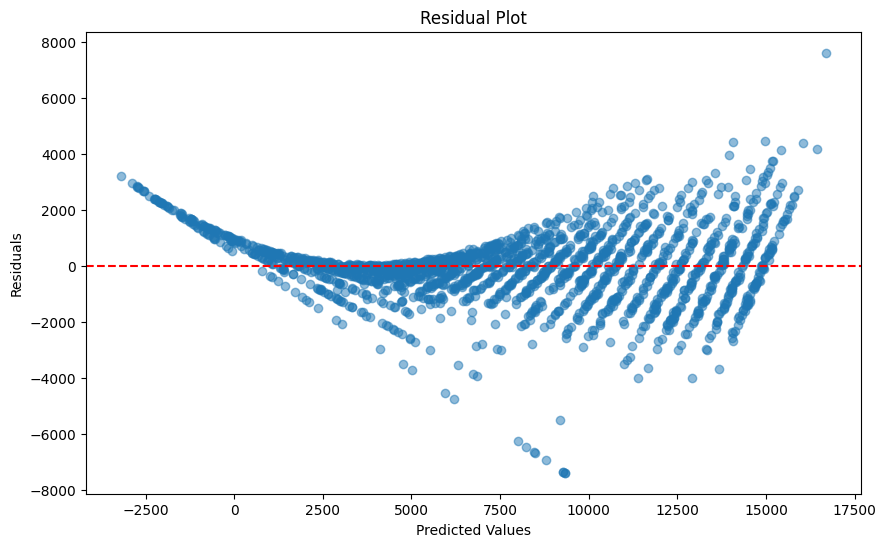

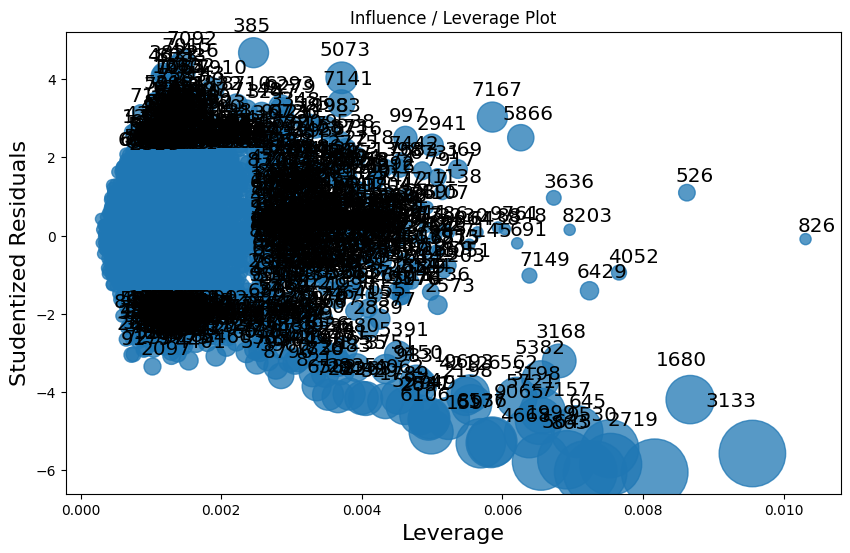

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')


# Data Cleaning
# Impute missing values in the Customers dataset
customers_df['age'].fillna(customers_df['age'].median(), inplace=True)

# Randomly assign genders to missing values
existing_genders = customers_df['gender'].dropna()
gender_distribution = existing_genders.value_counts(normalize=True)
missing_genders = customers_df['gender'].isnull()

np.random.seed(42)  # For reproducibility
random_genders = np.random.choice(gender_distribution.index, size=missing_genders.sum(), p=gender_distribution.values)
customers_df.loc[missing_genders, 'gender'] = random_genders

# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Feature Engineering
# Calculate Recency, Frequency, and Monetary Value (RFM) features
today_date = transactions_df['transaction_date'].max() + pd.Timedelta(days=1)
rfm = transactions_df.groupby('customer_id').agg({
    'transaction_date': lambda x: (today_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Calculate average amount per transaction
rfm['avg_amount_per_transaction'] = rfm['monetary'] / rfm['frequency']

# Define CLV as the monetary value for simplicity
rfm['clv'] = rfm['monetary']

# Merge RFM data with Customers data
merged_df = customers_df.merge(rfm, on='customer_id', how='left')

# Merge with Engagements data
merged_df = merged_df.merge(engagements_df, on='customer_id', how='left')

# Calculate the number of positive responses to marketing campaigns
positive_responses = marketing_df[marketing_df['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')

# Calculate the total number of responses to marketing campaigns
total_responses = marketing_df.groupby('customer_id').size().reset_index(name='total_responses')

# Merge with the Marketing data
merged_df = merged_df.merge(positive_responses, on='customer_id', how='left')
merged_df = merged_df.merge(total_responses, on='customer_id', how='left')
merged_df['positive_responses'].fillna(0, inplace=True)
merged_df['positive_response_rate'] = merged_df['positive_responses'] / merged_df['total_responses']

# Define features and target variable
X = merged_df.drop(columns=['customer_id', 'join_date', 'last_purchase_date', 'location', 'monetary', 'clv', 'positive_responses', 'total_responses'])
y = merged_df['clv']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Add a constant term for the intercept
X_encoded = sm.add_constant(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train a Linear Regression model using statsmodels' ols
formula = 'clv ~ ' + ' + '.join(X_encoded.columns.difference(['const']))
train_data = pd.concat([X_train, y_train], axis=1)
model = ols(formula=formula, data=train_data).fit()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Display the model summary
print(model.summary())

# Residuals
residuals = y_test - y_pred
normalized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# QQ-plot
plt.figure(figsize=(10, 6))
sm.qqplot(normalized_residuals, line='45')
plt.title('QQ-Plot of Residuals')
plt.show()

# Histogram of normalized residuals
plt.figure(figsize=(10, 6))
sns.histplot(normalized_residuals, kde=True)
plt.title('Histogram of Normalized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Influence / Leverage plot
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title('Influence / Leverage Plot')
plt.show()


In [101]:
merged_df

,customer_id,join_date,last_purchase_date,age,gender,location,recency,frequency,monetary,avg_amount_per_transaction,clv,number_of_site_visits,number_of_emails_opened,number_of_clicks,positive_responses,total_responses,positive_response_rate
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,81,6,3509.48,584.913333,3509.48,10,15,1,1.0,4,0.25
1,2,2021-09-08,2023-10-25,44.0,Male,Hillville,461,9,6081.32,675.702222,6081.32,285,49,51,2.0,4,0.50
2,3,2021-06-01,2022-11-27,44.0,Male,North Latoyatown,561,6,1454.87,242.478333,1454.87,192,73,25,1.0,2,0.50
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,640,20,7874.68,393.734000,7874.68,110,30,17,1.0,4,0.25
4,5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,366,24,15524.55,646.856250,15524.55,161,2,7,0.0,4,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,356,10,5498.20,549.820000,5498.20,119,47,16,0.0,3,0.00
9996,9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,541,12,5848.30,487.358333,5848.30,3,33,14,1.0,1,1.00
9997,9998,2023-09-17,2024-01-30,39.0,Male,New John,152,3,3503.13,1167.710000,3503.13,53,17,5,1.0,1,1.00
9998,9999,2022-05-10,2022-07-15,31.0,Female,Andrewland,688,12,6721.86,560.155000,6721.86,23,5,4,0.0,2,0.00
